In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
from torchmin import minimize
import scipy.stats as stats
from scipy.stats import chi2

In [2]:
# Parameter setzen
n_participants = 500
years = 10
effect_of_sex = 0.0
effect_of_age = -0.2

# random effects
var_intercept = 2
var_slope = 0.1

# fixed effects
weights = {'Systolic_BP': -0.1, 'Diastolic_BP': -0.1, 'Cholesterol': -0.2, 'Triglycerides': -0.2, 'BMI': -0.4, 'Creatinin': -0.1}


def simulate_data(num_participants):
    data = []
    # simulate data for each patient 
    for participant_id in range(1, n_participants + 1):
        age = np.random.randint(30, 61)  # patients are between 30 and 60
        gender = np.random.choice([0, 1])
        group = np.random.choice([0, 1])
        baseline_bp_sys = np.random.normal(120, 10)  # normal distributed systolic blood pressure vals
        baseline_bp_dia = np.random.normal(80, 10)  # normal ditributed diastolic blood pressure vals
        baseline_cholesterol = np.random.normal(200, 30)  # Cholesterin in mg/dL
        baseline_triglycerides = np.random.normal(150, 20)  # Triglyceride in mg/dL
        baseline_creatinin = np.random.normal(1,0.2) #creatinin in mg/dL
        baseline_bmi = np.random.normal(25, 4)  # BMI
        years_after_treatment = 0

        # randomly determine when the patient gets treatment 
        get_treatment = np.zeros((years), dtype=int)
        start_points = np.random.randint(3, years)
        for _ in range(years):
            get_treatment[start_points:] = 1

        # simulate random effects
        random_intercept = np.random.normal(0.0,np.sqrt(var_intercept))
        random_slope = np.random.normal(0.0, np.sqrt(var_slope))
        
        # simulate data for each year
        for year in range(years):
            # effect of the treatment
            if get_treatment[year] == 1:
                delta_bp = -2 * year  # treatment issues improvement of data  
                delta_cholesterol = -5 * year  # Cholesterin reduction of treatment
                delta_triglycerides = -3 * year  # Triglyceride reduction of treatment
                delta_creatinin = -0.08 * year
                years_after_treatment += 1
            else:
                delta_bp = -0.5 * year  # minimal natural improvement
                delta_cholesterol = -1 * year
                delta_triglycerides = -1 * year
                delta_creatinin = -0.01 * year
            
            # calculate the scores for each year
            sys_bp = baseline_bp_sys + delta_bp + np.random.normal(0, 5)
            dia_bp = baseline_bp_dia + delta_bp + np.random.normal(0, 5)
            cholesterol = max(100, baseline_cholesterol + delta_cholesterol + np.random.normal(0, 10))
            triglycerides = max(50, baseline_triglycerides + delta_triglycerides + np.random.normal(0, 5))
            creatinin = max(0.6, baseline_creatinin + delta_creatinin + np.random.normal(0, 0.1))

            bmi = baseline_bmi + np.random.normal(0, 0.5)  
            
            # calculate the test score 
            health_score = (150 + random_intercept +
                        weights['Systolic_BP'] * sys_bp +
                        weights['Diastolic_BP'] * dia_bp +
                        weights['Cholesterol'] * cholesterol +
                        weights['Triglycerides'] * triglycerides +
                        weights['BMI'] * bmi + 
                        weights['Creatinin'] * creatinin +
                        effect_of_sex * gender + 
                        effect_of_age * age +
                        random_slope * year)
            
            yearly_data = {
                'patient_id': participant_id,
                'Year': year,
                'Age': age,
                'Group': group,
                'Gender': gender,
                'Get_treatment': get_treatment[year] ,
                'Years_after_treatment' : years_after_treatment,
                'Systolic_BP': sys_bp,
                'Diastolic_BP': dia_bp,
                'Cholesterol': cholesterol,
                'Creatinin' : creatinin, 
                'Triglycerides': triglycerides,
                'BMI': bmi,
                'Health_Score': health_score
            }
            
            data.append(yearly_data)
            age += 1
    return data

# Erstelle einen DataFrame aus den gesammelten Daten
df = pd.DataFrame(simulate_data(n_participants))
data = simulate_data(n_participants)

In [3]:
df

,patient_id,Year,Age,Group,Gender,Get_treatment,Years_after_treatment,Systolic_BP,Diastolic_BP,Cholesterol,Creatinin,Triglycerides,BMI,Health_Score
0,1,0,54,0,1,0,0,130.680968,93.650305,207.536134,0.753508,150.467209,16.975680,36.399857
1,1,1,55,0,1,0,0,141.203205,86.926432,207.352190,0.726632,148.687930,16.830778,36.371688
2,1,2,56,0,1,0,0,133.540483,95.545187,209.739638,0.600000,143.204742,17.596066,36.500156
3,1,3,57,0,1,0,0,134.983494,99.085052,211.429661,0.839563,143.682458,16.932469,35.708178
4,1,4,58,0,1,0,0,135.653558,99.237106,232.138164,0.765754,147.372894,16.945163,30.646857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,500,5,44,1,0,0,0,101.790742,87.341160,230.896516,0.937259,164.995153,23.726794,34.383896
4996,500,6,45,1,0,0,0,114.741600,80.215680,186.741856,1.143216,164.550058,24.397105,42.637030
4997,500,7,46,1,0,0,0,96.326411,74.959255,225.334717,1.087246,169.773445,24.583648,36.376363
4998,500,8,47,1,0,1,1,94.437878,61.911006,201.264542,0.600000,158.713393,23.027888,45.771556


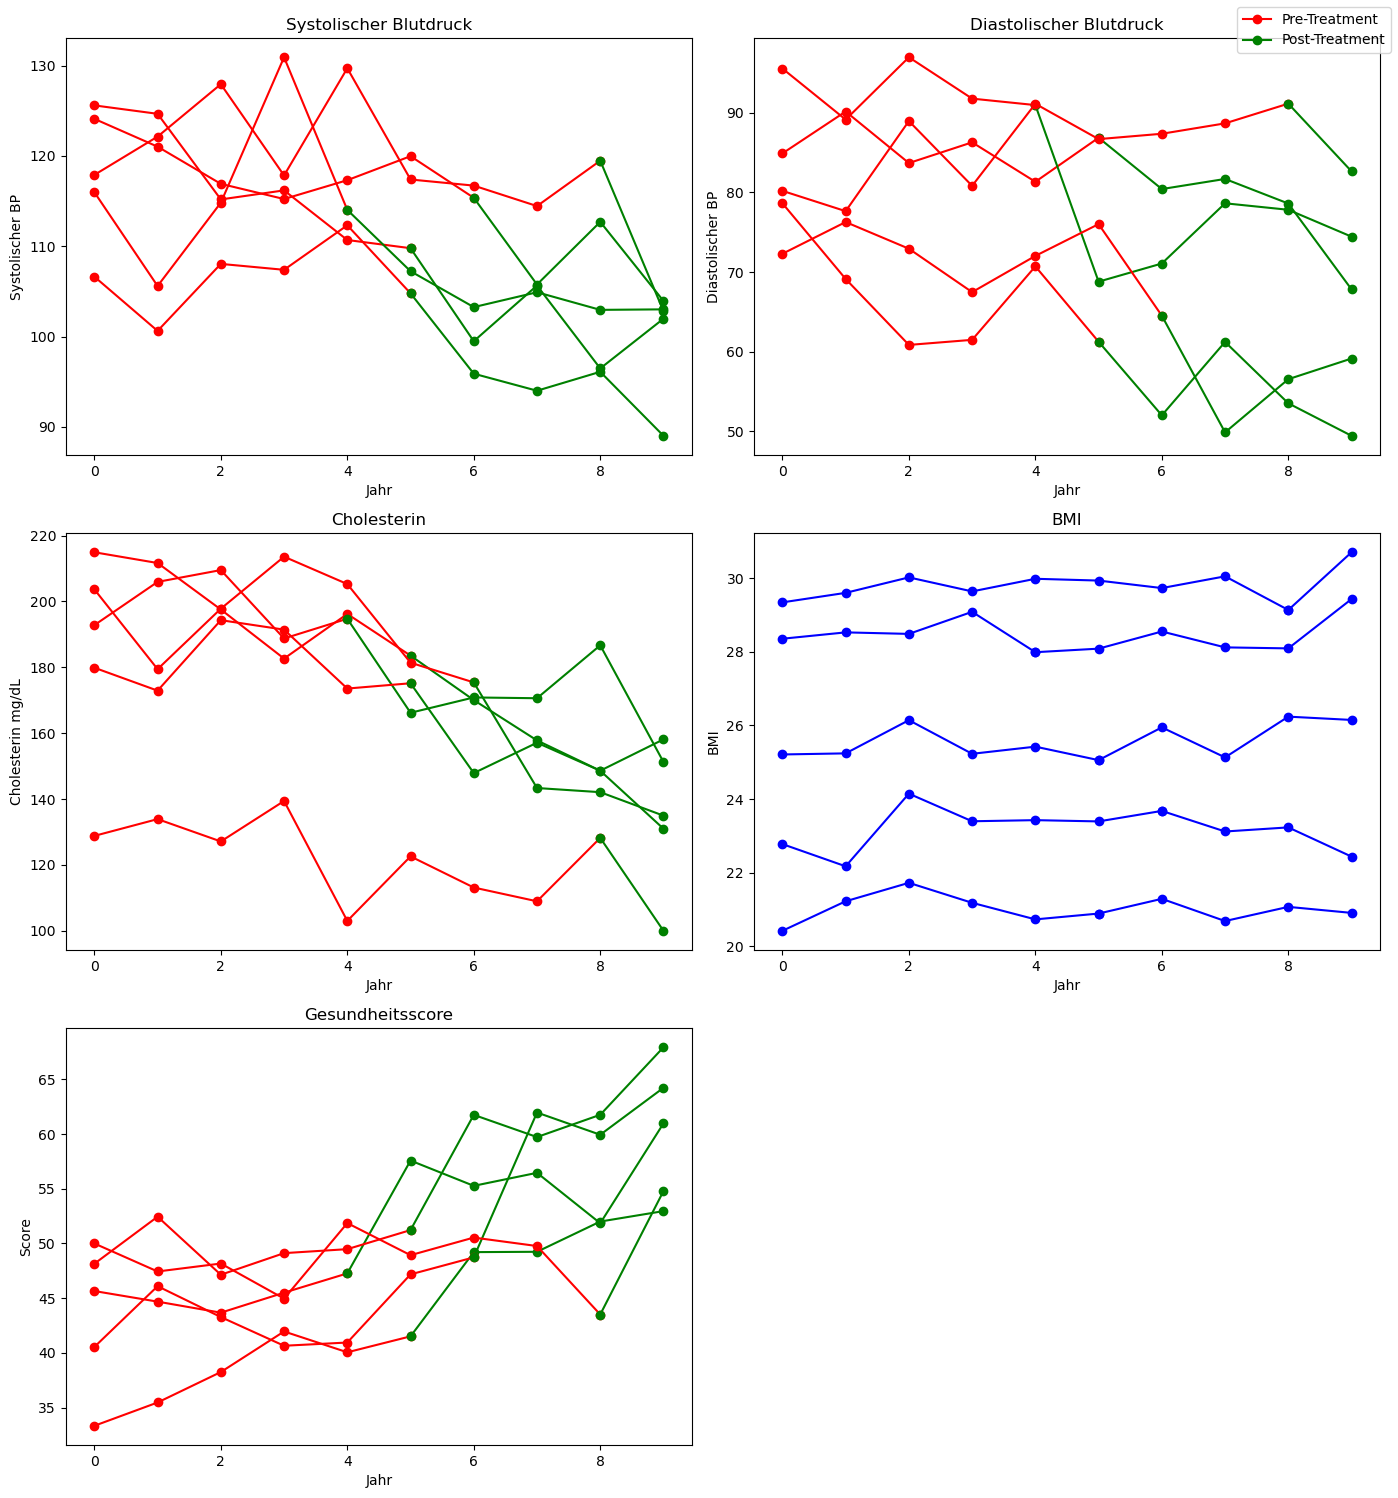

In [19]:
# choose 20 random patients
random_participants = np.random.choice(df['patient_id'].unique(), 5, replace=False)

# create plots for the chosen patients
fig, ax = plt.subplots(3, 2, figsize=(14, 15))  # 3x2 plot

# Farben für die Gruppen definieren
colors = {'Intervention': 'blue', 'Control': 'red'}

# Boolean flags to add legend only once
legend_added = {
    'Pre-Treatment': False,
    'Post-Treatment': False
}

# Plotte für jede Metrik und füge nur einmal die Legende für jede Gruppe hinzu
for participant in random_participants:
    subset = df[df['patient_id'] == participant]
    treatment_switch = subset[subset['Get_treatment'].diff() == 1].index
    group = subset['Group'].iloc[0]

    if not treatment_switch.empty:
        switch_point = treatment_switch[0] -1
        if not legend_added['Pre-Treatment']:
            ax[0, 0].plot(subset.loc[:switch_point, 'Year'], subset.loc[:switch_point, 'Systolic_BP'], marker='o', color="red", label='Pre-Treatment')
            legend_added['Pre-Treatment'] = True
        else:
            ax[0, 0].plot(subset.loc[:switch_point, 'Year'], subset.loc[:switch_point, 'Systolic_BP'], marker='o', color="red")

        if not legend_added['Post-Treatment']:
            ax[0, 0].plot(subset.loc[switch_point:, 'Year'], subset.loc[switch_point:, 'Systolic_BP'], marker='o', color="green", label='Post-Treatment')
            legend_added['Post-Treatment'] = True
        else:
            ax[0, 0].plot(subset.loc[switch_point:, 'Year'], subset.loc[switch_point:, 'Systolic_BP'], marker='o', color="green")

        ax[0, 1].plot(subset.loc[:switch_point, 'Year'], subset.loc[:switch_point, 'Diastolic_BP'], marker='o', color="red")
        ax[0, 1].plot(subset.loc[switch_point:, 'Year'], subset.loc[switch_point:, 'Diastolic_BP'], marker='o', color="green")
        ax[1, 0].plot(subset.loc[:switch_point, 'Year'], subset.loc[:switch_point, 'Cholesterol'], marker='o', color="red")
        ax[1, 0].plot(subset.loc[switch_point:, 'Year'], subset.loc[switch_point:, 'Cholesterol'], marker='o', color="green")
        ax[1, 1].plot(subset.loc[:switch_point, 'Year'], subset.loc[:switch_point, 'BMI'], marker='o', color="blue")
        ax[1, 1].plot(subset.loc[switch_point:, 'Year'], subset.loc[switch_point:, 'BMI'], marker='o', color="blue")
        ax[2, 0].plot(subset.loc[:switch_point, 'Year'], subset.loc[:switch_point, 'Health_Score'], marker='o', color="red")
        ax[2, 0].plot(subset.loc[switch_point:, 'Year'], subset.loc[switch_point:, 'Health_Score'], marker='o', color="green")
    else:
        ax[0, 0].plot(subset['Year'], subset['Systolic_BP'], marker='o', color="blue")
        ax[0, 1].plot(subset['Year'], subset['Diastolic_BP'], marker='o', color="blue")
        ax[1, 0].plot(subset['Year'], subset['Cholesterol'], marker='o', color="blue")
        ax[1, 1].plot(subset['Year'], subset['BMI'], marker='o', color="blue")
        ax[2, 0].plot(subset['Year'], subset['Health_Score'], marker='o', color="blue")


# set labels and titles
ax[0, 0].set_title('Systolischer Blutdruck')
ax[0, 0].set_xlabel('Jahr')
ax[0, 0].set_ylabel('Systolischer BP')
ax[0, 1].set_title('Diastolischer Blutdruck')
ax[0, 1].set_xlabel('Jahr')
ax[0, 1].set_ylabel('Diastolischer BP')
ax[1, 0].set_title('Cholesterin')
ax[1, 0].set_xlabel('Jahr')
ax[1, 0].set_ylabel('Cholesterin mg/dL')
ax[1, 1].set_title('BMI')
ax[1, 1].set_xlabel('Jahr')
ax[1, 1].set_ylabel('BMI')
ax[2, 0].set_title('Gesundheitsscore')
ax[2, 0].set_xlabel('Jahr')
ax[2, 0].set_ylabel('Score')

# Add legend once
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

ax[2, 1].axis('off')

plt.tight_layout()
plt.show()

In [4]:
# return index of first occur of 'pat' in collumn patient_id
def get_ind(pat, df):
    return np.where(df['patient_id'] == pat)[0]

# returns a block diagonal matrix of a list of matrices
def block_diag_list(arrs_list):
    shape = torch.sum(torch.tensor([a.shape for a in arrs_list], dtype=torch.int32), dim=0)
    dtype = arrs_list[0].dtype
    device = arrs_list[0].device

    out = torch.zeros(*shape.tolist(), dtype=dtype, device=device)

    r, c = 0, 0
    for a in arrs_list:
        rows, cols = a.shape
        out[r:r + rows, c:c + cols] = a
        r += rows
        c += cols
    return out

# Random effects design matrix (Datenmatrix) for each patient
def calculate_Zlist(df, random_effects_keys):
    Z_list = [torch.cat((
        torch.ones(len(get_ind(pat, df)), 1), 
        torch.from_numpy(np.array(df.loc[get_ind(pat, df), random_effects_keys]))
                        ), -1).to(torch.float32)
                for pat in df['patient_id'].unique()]
    return Z_list

# Fixed effects design matrix (Datenmatrix) for each patient
def calculate_Xlist(df, fixed_effects_keys):
    X_list = [torch.cat((
        torch.ones(len(get_ind(pat, df)), 1), 
        torch.from_numpy(np.array(df.loc[get_ind(pat, df), fixed_effects_keys]))
                         ), -1).to(torch.float32)
                for pat in df['patient_id'].unique()]
    return X_list

def likelihood_ratio(Lmin, Lmax, diff):
    return  2 * (Lmax - Lmin)

In [5]:
num_simulations = 100
#keys for random and fixed effects in the matrix
fixed_effects_keys_full= ['Age', 'Gender', 'Systolic_BP', 'Diastolic_BP', 'Cholesterol', 'Triglycerides', 'BMI', 'Creatinin', 'Get_treatment']
random_effects_keys_full = ['Years_after_treatment']
#keys for random and fixed effects in the matrix
fixed_effects_keys_red = ['Age', 'Systolic_BP', 'Diastolic_BP', 'Cholesterol', 'Triglycerides', 'BMI','Creatinin', 'Get_treatment']
random_effects_keys_red = ['Years_after_treatment']

n_fixed_eff_full = len(fixed_effects_keys_full) + 1
n_rand_eff_full = len(random_effects_keys_full) + 1
n_fixed_eff_red = len(fixed_effects_keys_red) + 1
n_rand_eff_red = len(random_effects_keys_red) + 1
softplus = torch.nn.Softplus()
D_param_full = torch.randn(n_rand_eff_full, requires_grad=True) # Learnable parameter for diagonal covariance matrix
D_param_red = torch.randn(n_rand_eff_red, requires_grad=True) # Learnable parameter for diagonal covariance matrix
lrt_results = []

for i in range(num_simulations):
    data = pd.DataFrame(simulate_data(200), columns=['patient_id', 'Year', 'Age', 'Group', 'Gender', 'Get_treatment', 'Years_after_treatment', 'Systolic_BP', 'Diastolic_BP', 
                                                  'Cholesterol', 'Triglycerides', 'BMI','Creatinin', 'Health_Score'])
    N = len(data)
    Z_list_full = calculate_Zlist(data, random_effects_keys_full) # Random effects design matrix (Datenmatrix) for each patient
    X_list_full = calculate_Xlist(data, fixed_effects_keys_full) # Fixed effects design matrix (Datenmatrix) for each patient
    y_full = torch.from_numpy(np.array(data['Health_Score'])).to(torch.float32) # Response variable: Test scores
    X_tilde_list_full = [torch.cat((X_i, torch.zeros((n_rand_eff_full, n_fixed_eff_full)))) for X_i in X_list_full] # Defining list of X tilde (eq. 2.7 p. 63)
    y_e_full = torch.cat([torch.cat((y_full[get_ind(pat,data)], torch.zeros(n_rand_eff_full))).unsqueeze(-1) for pat in data['patient_id'].unique()]) # Augmented response vector y_e (eq. 2.11 p. 65)

    def calculate_likelihood_full(D_param_full): 
        # Ensure that the diagonal covariance matrix has only positive values
        Delta = torch.diag(softplus(D_param_full))
        det_Delta = torch.det(Delta)  

        # Defining list of Z tilde (eq. 2.7 p. 63)
        Z_tilde_list_full = [torch.cat((Z_i, Delta)) for Z_i in Z_list_full]
        # Matrix X_e (eq. 2.11 p. 65)
        X_e_full = torch.cat((block_diag_list(Z_tilde_list_full), torch.cat(X_tilde_list_full)), -1)

        # Calculate MLE estimates of random and fixed effects with current set of covariance Parameters (eq. 2.11 p. 65)
        pred = torch.inverse((X_e_full.t() @ X_e_full)) @ X_e_full.t() @ y_e_full
        # Calculate MLE estimates of the noise sigma with current set of covariance Parameters (eq. 2.12 p. 65)
        pred_sigma = torch.sum((y_e_full - X_e_full @ pred) ** 2) / N

        # Calculate the logarithm of the likelihood function in (eq. 2.13 p. 65)
        likelihood = -N/2 * (1 + torch.log(torch.tensor(2 * torch.pi)) + torch.log(pred_sigma))
        likelihood += torch.log(torch.stack([det_Delta/torch.det(Z_i_tilde.t() @ Z_i_tilde).sqrt() for Z_i_tilde in Z_tilde_list_full])).sum()
        return - likelihood
    
    result_full = minimize(calculate_likelihood_full, D_param_full, method='bfgs', max_iter=6)
    Lmax = result_full.fun

    Z_list_red = calculate_Zlist(data, random_effects_keys_red) # Random effects design matrix (Datenmatrix) for each patient
    X_list_red = calculate_Xlist(data, fixed_effects_keys_red) # Fixed effects design matrix (Datenmatrix) for each patient
    y_red = torch.from_numpy(np.array(data['Health_Score'])).to(torch.float32) # Response variable: Test scores
    X_tilde_list_red = [torch.cat((X_i, torch.zeros((n_rand_eff_red, n_fixed_eff_red)))) for X_i in X_list_red] # Defining list of X tilde (eq. 2.7 p. 63)
    y_e_red = torch.cat([torch.cat((y_red[get_ind(pat,data)], torch.zeros(n_rand_eff_red))).unsqueeze(-1) for pat in data['patient_id'].unique()]) # Augmented response vector y_e (eq. 2.11 p. 65)

    def calculate_likelihood_reduced(D_param_red):
        # Ensure that the diagonal covariance matrix has only positive values
        Delta_r = torch.diag(softplus(D_param_red))
        det_Delta_r = torch.det(Delta_r)  

        # Defining list of Z tilde (eq. 2.7 p. 63)
        Z_tilde_list_red = [torch.cat((Z_i, Delta_r)) for Z_i in Z_list_red]
        # Matrix X_e (eq. 2.11 p. 65)
        X_e_red = torch.cat((block_diag_list(Z_tilde_list_red), torch.cat(X_tilde_list_red)), -1)

        # Calculate MLE estimates of random and fixed effects with current set of covariance Parameters (eq. 2.11 p. 65)
        pred_red = torch.inverse((X_e_red.t() @ X_e_red)) @ X_e_red.t() @ y_e_red
        # Calculate MLE estimates of the noise sigma with current set of covariance Parameters (eq. 2.12 p. 65)
        pred_sigma_red = torch.sum((y_e_red - X_e_red @ pred_red) ** 2) / N

        # Calculate the logarithm of the likelihood function in (eq. 2.13 p. 65)
        likelihood = -N/2 * (1 + torch.log(torch.tensor(2 * torch.pi)) + torch.log(pred_sigma_red))
        likelihood += torch.log(torch.stack([det_Delta_r/torch.det(Z_i_tilde_r.t() @ Z_i_tilde_r).sqrt() for Z_i_tilde_r in Z_tilde_list_red])).sum()
        return - likelihood
    result_reduced = minimize(calculate_likelihood_reduced, D_param_red, method='bfgs', max_iter=6)
    Lmin = result_reduced.fun

    lrt_results.append(likelihood_ratio(Lmin,Lmax,1))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


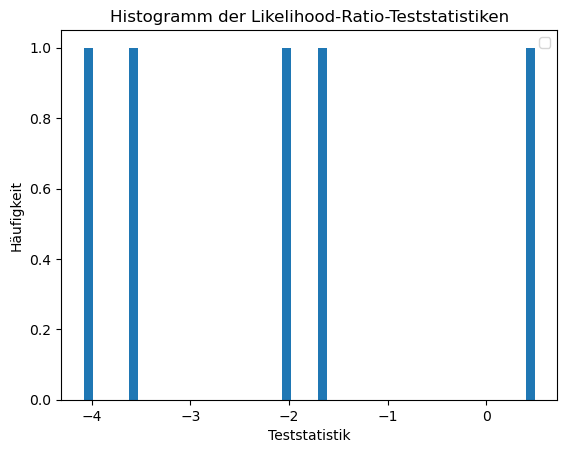

In [18]:
# Histogramm der Teststatistiken erstellen
plt.hist(lrt_results, bins=50) # balken dünner und so dass man mit chi quadrat vergleichen kann

# Chi-Quadrat-Verteilung mit einem Freiheitsgrad plotten (für Vergleich)
#x = np.linspace(0, 10, 1000)
#plt.plot(-x, chi2.pdf(x, df=1), 'r-', lw=1, label='Chi-Squared (df=1)')

# Beschriftungen hinzufügen
plt.title('Histogramm der Likelihood-Ratio-Teststatistiken')
plt.xlabel('Teststatistik')
plt.ylabel('Häufigkeit')
plt.legend()

# Histogramm anzeigen
plt.show()